This notebook has been inspired by [Q* Learning with FrozenLakev2.ipynb](https://colab.research.google.com/github/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Q_Learning_with_FrozenLakev2.ipynb#scrollTo=Xr9nI6dcQM8I) and [Deep Reinforcement Learning Course](https://huggingface.co/learn/deep-rl-course/unit0/introduction?fw=pt) by Thomas Simonini

# Day 3 : Policy Iteration Algorithm

## Policy Iteration Algorithm


Policy Iteration Algorithm works by alternating between evaluating the existing policy and making the policy greedy with respect to the existing value function. It consists of three steps:

1. Initialization: initialize the value function as well as the policy (randomly).
2. Policy Evaluation: uses the Bellman equation as an update rule to iteratively construct the value function.
3. Policy Improvement: chooses the policy that maximizes the value function of the original policy (greedy).

A pseudocode for the algorithm is given below from the textbook Reinforcement Learning: An Introduction, by Richard S. Sutton and Andrew G. Barto.



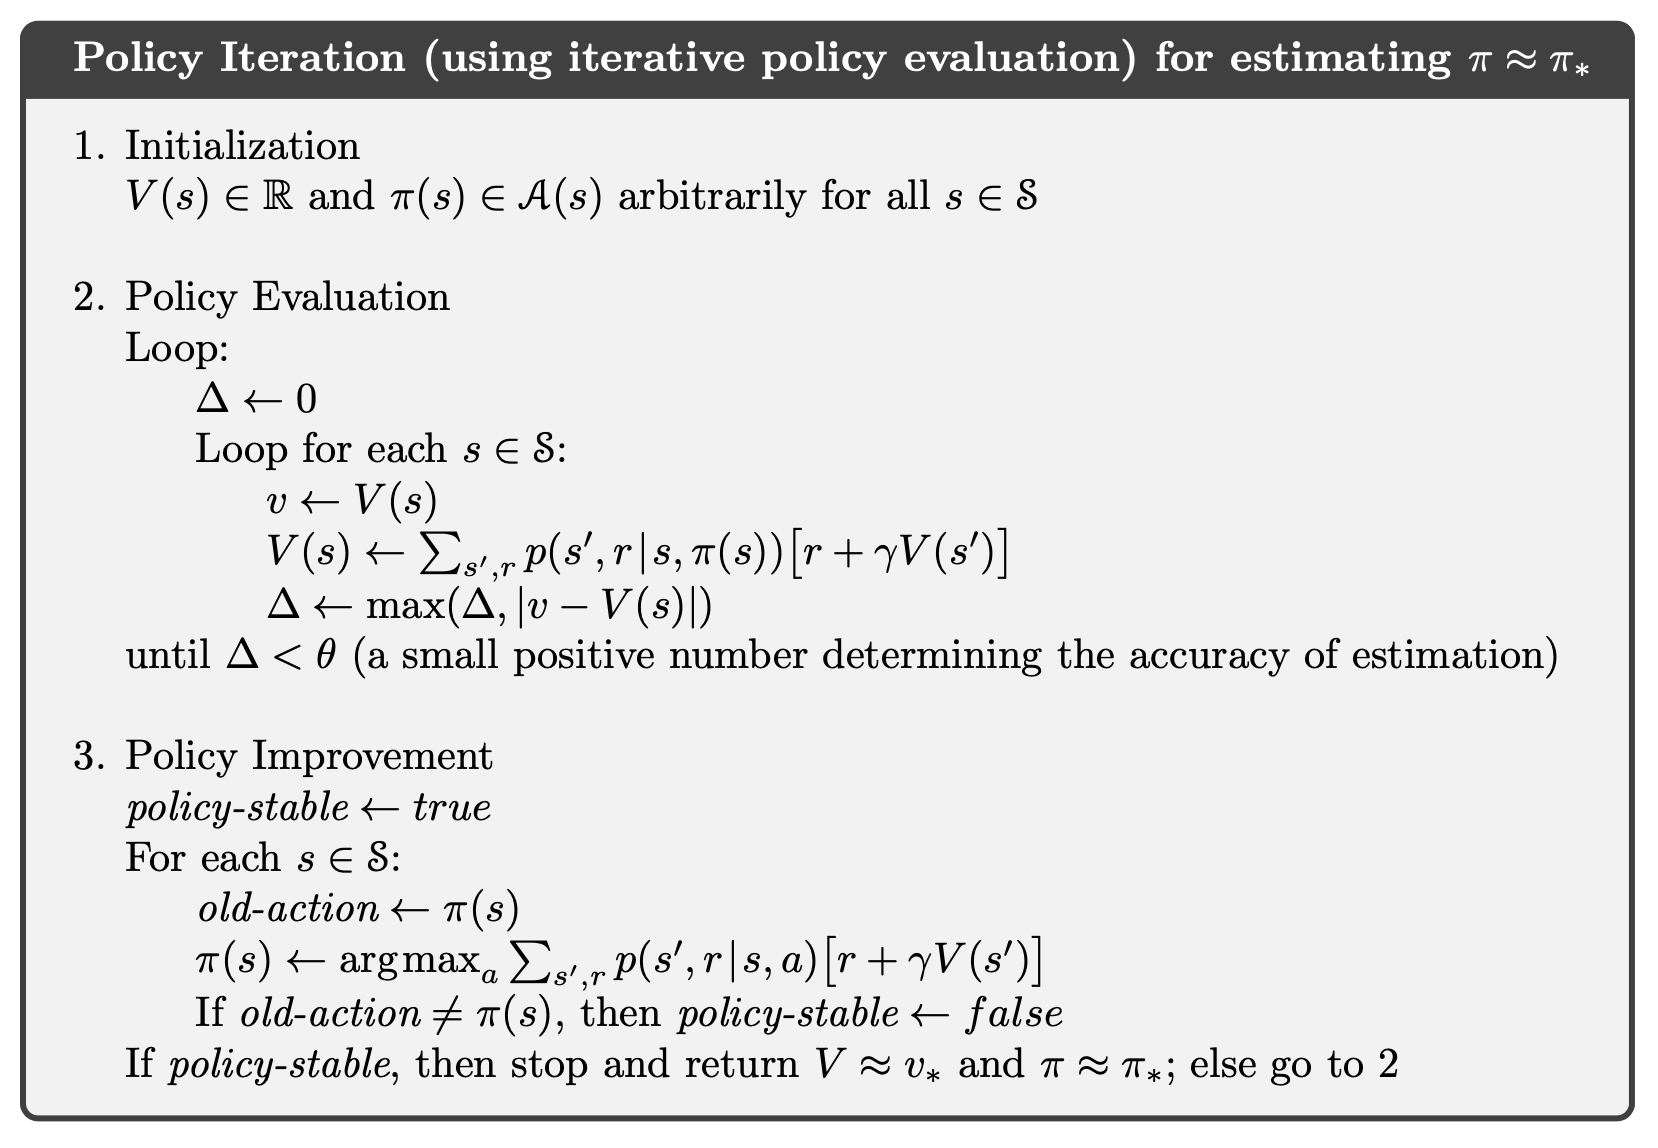



## OpenAI Gym

[OpenAI Gym](https://www.gymlibrary.dev/) is a toolkit for developing and comparing reinforcement learning (RL) algorithms. It consists of a growing suite of environments (from simulated robots to Atari games), and a site for comparing and reproducing results. OpenAI Gym provides a diverse suite of environments that range from easy to difficult and involve many different kinds of data.

Creating and Interacting with gym environments is very simple.

```
import gym
env = gym.make("CartPole-v1")
observation, info = env.reset(seed=42)

for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, done, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()
env.close()
```

Following are the definitions of some common terminologies used.

**Reset:** Resets the environment to an initial state and returns the initial observation. <br>
**Step:** Run one timestep of the environment's dynamics.<br>
**Observation:** The observed state of the environment.<br>
**Action:** An action provided by the agent.<br>
**Reward:** The amount of reward returned as a result of taking the action.<br>
**Terminated:** Whether a terminal state (as defined under the MDP of the task) is reached.<br>
**Truncated:** Whether a truncation condition outside the scope of the MDP is satisfied. Typically a timelimit, but could also be used to indicate agent physically going out of bounds.<br>
**Info:** This contains auxiliary diagnostic information (helpful for debugging, learning, and logging).<br>
**Action Space:** This attribute gives the format of valid actions. It is of datatype Space provided by Gym. For example, if the action space is of type Discrete and gives the value Discrete(2), this means there are two valid discrete actions: 0 & 1.<br>
**Observation:** This attribute gives the format of valid observations. It is of datatype Space provided by Gym. For example, if the observation space is of type Box and the shape of the object is (4,), this denotes a valid observation will be an array of 4 numbers.<br>

Note: Previously, `terminated` and `truncated` used to be merged under one variable `done`. <br>


We will use OpenAI Gym for Frozen Lake (2D) and Cart Pole (1D) environments.

In [ ]:
import numpy as np
import gym
import random

# Policy Iteration Algorithm on 1D gridworld

Let's consider a simple MDP where you are a robot trying to navigate through a grid world. The grid world is represented by a 3x3 grid, and your task is to reach the goal state located at the bottom-right corner of the grid.

The two actions available to you are:


1.   Move right
2.   Move down


The possible states in the grid world are the cells in the grid. So, in this case, there are a total of 9 states.

Here's a visualization of the grid world:


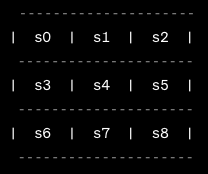

The starting state is s0 (top-left corner), and the goal state is s8 (bottom-right corner).

The dynamics of the MDP are as follows:



1.   If you choose the "Move right" action, you will transition to the state on your right (if it is a valid state). If the current state is on the right-most column (s2, s5, or s8), you will remain in the same state.

2.   If you choose the "Move down" action, you will transition to the state below you (if it is a valid state). If the current state is on the bottom row (s6, s7, or s8), you will remain in the same state.



The rewards for this MDP can be defined as follows:



1.   If you reach the goal state (s8), you receive a reward of +10.

2.   If you move into any other state, you receive a reward of 0.


The MDP is episodic, meaning that once you reach the goal state, the episode ends, and a new episode starts from the initial state.

## Implementation of Policy Iteration

In [ ]:
# Create the gridworld environment
grid_world = np.array([[0, 0, 0],
                      [0, 0, 0],
                      [0, 0, 1]])

rewards = np.array([[0, 0, 0],
                    [0, 0, 0],
                    [0, 0, 10]])

actions = np.array(['right', 'down'])

states = np.array([(i, j) for i in range(grid_world.shape[0]) for j in range(grid_world.shape[1]) if grid_world[i, j] == 0])

# Define the next state function
def get_next_state(current_state, action):
    i, j = current_state
    if action == 'right':
        j = min(j + 1, grid_world.shape[1] - 1)
    elif action == 'down':
        i = min(i + 1, grid_world.shape[0] - 1)
    return (i, j)

In [ ]:
# Policy evaluation
def evaluate_policy(grid, rewards, actions, states, V, pi, gamma, theta):

    """Applies the policy evaluation algorithm.
    Args:
        env (Environment): gridworld environment
        V (array): numpy array representing the value function
        pi (array): numpy array representing the policy
        gamma (float): gamma parameter (between 0 and 1)
        theta (float): threshold parameter that defines when the change in the value function is negligible
    """

    state_size = states.shape[0]
    action_size = actions.shape[0]

    delta = float('inf')
    while delta > theta:
    delta = 0
    for s in states:
        v = V[s]
        bellman_update(grid, rewards, actions, states, V, pi, s, gamma)
        delta = max(delta, np.linalg.norm(v - V[s]))
    return V

def bellman_update(grid, rewards, actions, states, V, pi, s, gamma):
    """Mutate V according to the Bellman update equation."""
    i, j = s
    a = pi[i, j]
    sp = get_next_state(s, a)
    r = rewards[i, j]
    v = r + gamma * V[sp]
    V[s] = v


In [ ]:
# Policy improvement
def improve_policy(grid, rewards, actions, states, V, pi, gamma):
    """Applies the Policy Improvement step.
    Args:
        env (Environment): gridworld environment
        v (array): numpy array representing the value function
        pi (array): numpy array representing the policy
        gamma (float): gamma parameter (between 0 and 1)
    """
    policy_stable = True
    state_size = states.shape[0]

    for s in states:
        old = pi[s].copy()
        q_greedify_policy(grid, rewards, actions, states, V, pi, s, gamma)

        if not np.array_equal(pi[s], old):
            policy_stable = False

    return pi, policy_stable

def q_greedify_policy(grid, rewards, actions, states, V, pi, s, gamma):
    """Mutate pi to be greedy with respect to the q-values induced by V."""
    i, j = s
    best_action = None
    best_value = float('-inf')
    for a in actions:
        sp = get_next_state(s, a)
        r = rewards[i, j]
        v = r + gamma * V[sp]
        if v > best_value:
            best_value = v
            best_action = a
    pi[i, j] = best_action


In [ ]:
# Policy iteration
def policy_iteration(grid, rewards, actions, states, gamma, theta):

    V = np.ones_like(grid, dtype=float)
    pi = np.random.choice(actions, size=grid.shape)
    policy_stable = False

    while not policy_stable:
        V = evaluate_policy(grid, rewards, actions, states, V, pi, gamma, theta)
        pi, policy_stable = improve_policy(grid, rewards, actions, states, V, pi, gamma)

    return V, pi

In [ ]:

gamma = 0.9
theta = 1e-6

V = np.ones_like(grid_world, dtype=float)
pi = np.random.choice(actions, size=grid_world.shape)


# Policy Iteration Algorithm
policy_iteration(grid_world, rewards, actions, states, gamma, theta)

print("The policy using Policy Iteration Algorithm:")
print(pi)


The policy using Policy Iteration Algorithm:
[['down' 'right' 'right']
 ['down' 'down' 'down']
 ['right' 'down' 'down']]


# Policy Iteration Algorithm on 2D Frozen Lake

Frozen lake is a toy text environment involves crossing a frozen lake from start to goal without falling into any holes by walking over the frozen lake. <br>

We can also set the lake to be slippery so that the agent does not always move in the intended direction. \but here, we will only look at the non-slippery case. But you are welcome to try the slippery one.<br>

You can read more about the environment [here](https://gymnasium.farama.org/environments/toy_text/frozen_lake/).

![Frozen Lake](https://gymnasium.farama.org/_images/frozen_lake.gif)


|   |   |
|---|---|
| Action Space | Discrete(4) |
| Observation Space | Discrete(16) |
| Import | `gym.make("FrozenLake-v1")` |


Frozen lake involves crossing a frozen lake from Start(S) to Goal(G) without falling into any Holes(H)
by walking over the Frozen(F) lake.
The agent may not always move in the intended direction due to the slippery nature of the frozen lake.


### Action Space
The agent takes a 1-element vector for actions.
The action space is `(dir)`, where `dir` decides direction to move in which can be:

- 0: LEFT
- 1: DOWN
- 2: RIGHT
- 3: UP

### Observation Space
The observation is a value representing the agent's current position as
current_row * nrows + current_col (where both the row and col start at 0).
For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15.
The number of possible observations is dependent on the size of the map.
For example, the 4x4 map has 16 possible observations.

### Rewards

Reward schedule:
- Reach goal(G): +1
- Reach hole(H): 0
- Reach frozen(F): 0

### Arguments

```
gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
```

`desc`: Used to specify custom map for frozen lake. For example,

    desc=["SFFF", "FHFH", "FFFH", "HFFG"].

    A random generated map can be specified by calling the function `generate_random_map`. For example,

    ```
    from gym.envs.toy_text.frozen_lake import generate_random_map

    gym.make('FrozenLake-v1', desc=generate_random_map(size=8))
    ```

`map_name`: ID to use any of the preloaded maps.

    "4x4":[
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
        ]

    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG",
    ]

`is_slippery`: True/False. If True will move in intended direction with
probability of 1/3 else will move in either perpendicular direction with
equal probability of 1/3 in both directions.

    For example, if action is left and is_slippery is True, then:
    - P(move left)=1/3
    - P(move up)=1/3
    - P(move down)=1/3


## Implementation of Policy Iteration

In [ ]:
# Policy evaluation
def evaluate_policy(env, V, pi, gamma, theta):
    """Applies the policy evaluation algorithm.
        Args:
            env (Environment): gridworld environment
            V (array): numpy array representing the value function
            pi (array): numpy array representing the policy
            gamma (float): gamma parameter (between 0 and 1)
            theta (float): threshold parameter that defines when the change in the value function is negligible
    """

    state_size = env.observation_space.n

    delta = float('inf')
    while delta > theta:
    delta = 0
    for s in range(state_size):
        v = V[s]
        bellman_update(env, V, pi, s, gamma)
        delta = max(delta, abs(v - V[s]))
    return V

def bellman_update(env, V, pi, s, gamma):
    """Mutate V according to the Bellman update equation."""
    action_size = env_2D.action_space.n
    v = 0
    for a in range(action_size):
    temp = 0
    P = np.array(env.P[s][a])
    for i in range(np.shape(P)[0]):
        sp = int(P[i][1])
        p = P[i][0]
        r = P[i][2]
        temp += p * (r + gamma * V[sp])
    v += pi[s][a] * temp
    V[s] = v


In [ ]:
# Policy improvement
def improve_policy(env, V, pi, gamma):
    """Applies the Policy Improvement step.
    Args:
        env (Environment): gridworld environment
        v (array): numpy array representing the value function
        pi (array): numpy array representing the policy
        gamma (float): gamma parameter (between 0 and 1)
    """
    policy_stable = True
    state_size = env.observation_space.n

    for s in range(state_size):
        old = pi[s].copy()
        q_greedify_policy(env, V, pi, s, gamma)

        if not np.array_equal(pi[s], old):
            policy_stable = False

    return pi, policy_stable

def q_greedify_policy(env, V, pi, s, gamma):
    """Mutate pi to be greedy with respect to the q-values induced by V."""
    action_size = env_2D.action_space.n
    q = np.zeros(action_size)
    for a in range(action_size):
    temp = 0
    P = np.array(env.P[s][a])
    for i in range(np.shape(P)[0]):
        sp = int(P[i][1])
        p = P[i][0]
        r = P[i][2]
        temp += p * (r + gamma * V[sp])
    q[a] = temp
    a_greedy = np.argmax(q)
    for i in range(len(pi[s])):
    if i == a_greedy:
        pi[s][i] = 1
    else:
        pi[s][i] = 0

In [ ]:
# Policy iteration
def policy_iteration(env, gamma, theta):
    state_size = env_2D.observation_space.n
    action_size = env_2D.action_space.n

    V = np.zeros(state_size)
    pi = np.ones((state_size, action_size))/action_size
    policy_stable = False

    while not policy_stable:
        V = evaluate_policy(env, V, pi, gamma, theta)
        pi, policy_stable = improve_policy(env, V, pi, gamma)

    return V, pi

In [ ]:
# Create the environment
env_2D = gym.make("FrozenLake-v1", is_slippery=True, render_mode="rgb_array",new_step_api=True)

state_size = env_2D.observation_space.n
action_size = env_2D.action_space.n


In [ ]:
gamma = 0.9
theta = 0.1

V = np.zeros(state_size)
pi = np.ones((state_size, action_size))/action_size

# Policy Iteration Algorithm
V, pi = policy_iteration(env_2D, gamma, theta)

print("The policy using Policy Iteration Algorithm:")
print(pi)

## Visualization

In [ ]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name, env, policy, max_steps=10000):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    for t in range(max_steps):
        vid.capture_frame()
        action = np.argmax(pi[state,:])
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        print(f"state: {state}, action: {action}",next_state, reward, done)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

In [ ]:
show_video_of_model("lake", env_2D, pi, max_steps=10000)

state: 0, action: 1 4 0.0 False
state: 4, action: 0 8 0.0 False
state: 8, action: 3 9 0.0 False
state: 9, action: 1 8 0.0 False
state: 8, action: 3 4 0.0 False
state: 4, action: 0 4 0.0 False
state: 4, action: 0 8 0.0 False
state: 8, action: 3 4 0.0 False
state: 4, action: 0 8 0.0 False
state: 8, action: 3 9 0.0 False
state: 9, action: 1 10 0.0 False
state: 10, action: 0 14 0.0 False
state: 14, action: 1 14 0.0 False
state: 14, action: 1 14 0.0 False
state: 14, action: 1 15 1.0 True


In [ ]:
show_video("lake")